<a href="https://colab.research.google.com/github/amantimalsina/Poly-Pytorch/blob/main/Poly_Learn_Sobel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
!pip install datasets wandb matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [3]:
#%%%%%%
import os
import random
from tqdm import tqdm
import wandb
#%%%%%%
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
#%%%%%%
import matplotlib.pyplot as plt
#%%%%%%
from datasets import load_dataset
from torch.utils.data import Dataset

## Dataset Prep

In [4]:
class ImagenetteDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        image = np.array(image)
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        if self.transform:
            image = self.transform(image)
        return image

# Needed a custom collate function because I was getting error when pytorch stacked tensors in dataloader.
def collate_fn(batch):
    min_h = min([img.shape[1] for img in batch])
    min_w = min([img.shape[2] for img in batch])

    processed_batch = torch.stack([transforms.CenterCrop((min_h, min_w))(img) for img in batch])
    return processed_batch

ds = load_dataset("frgfm/imagenette", "320px")

transform = transforms.Compose([
    transforms.Grayscale(),
])

train_dataset = ImagenetteDataset(ds['train'], transform=transform)
val_dataset = ImagenetteDataset(ds['validation'], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

for batch in train_dataloader:
    print(f"Batch shape: {batch.shape}")
    print(f"Batch min: {batch.min()}, max: {batch.max()}")
    break

print("DataLoader setup complete!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Batch shape: torch.Size([32, 1, 320, 320])
Batch min: 0.0, max: 1.0
DataLoader setup complete!


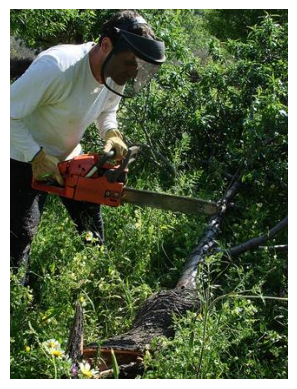

In [5]:
image_np = np.array(ds['train'][2500]['image'])
plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.show()

## Model and Filters

In [6]:
class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()

        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        nn.init.uniform_(self.conv.weight, -0.1, 0.1)


    def forward(self, x):
        if torch.cuda.is_available():
            x = x.cuda()

        G_x = self.conv(x)
        G_y = self.conv(x.transpose(-2, -1)).transpose(-2, -1)

        return torch.sqrt(G_x**2 + G_y**2)


In [7]:
def apply_Sobel(img):
  sobel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

  if torch.cuda.is_available():
      img = img.cuda()
      sobel = sobel.cuda()

  G_x = F.conv2d(img, sobel, padding=1)
  G_y = F.conv2d(img.transpose(-2, -1), sobel, padding=1).transpose(-2, -1)
  return torch.sqrt(G_x**2 + G_y**2).squeeze(1)

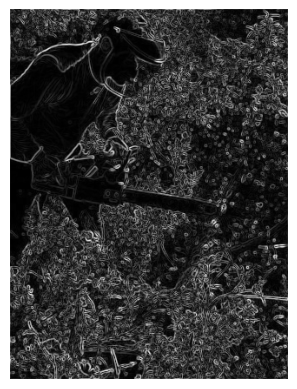

In [8]:
image = train_dataset[2500]
image_np = np.array(image)
sobel_image = apply_Sobel(torch.from_numpy(image_np).float()).squeeze(0)
sobel_image = sobel_image.cpu().detach().numpy()
plt.imshow(sobel_image, cmap='gray')
plt.axis('off')
plt.show()

### Combined Loss Function


In [9]:
def sobel_structure_loss(model):
    sobel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    if torch.cuda.is_available():
        sobel = sobel.cuda()

    return nn.MSELoss()(model.conv.weight, sobel)

In [10]:
def combined_loss(output, target, model, lambda_structure=0.5):
    mse_loss = nn.MSELoss()(output, target)
    structure_loss = sobel_structure_loss(model)
    return mse_loss + lambda_structure * structure_loss

## Training

In [11]:
model = Sobel()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sobel(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [ ]:
wandb.init(project="sobel-filter-learning")
num_epochs = 5
patience = 2
min_delta = 0.001

best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = batch
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            model = model.cuda()

        inputs = (inputs - inputs.mean()) / inputs.std() # Normalize inputs

        optimizer.zero_grad()
        outputs = model(inputs)
        target = torch.stack([apply_Sobel(img.unsqueeze(0)) for img in inputs]) # Add a dimension to the image
        loss = combined_loss(outputs, target, model)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)    # Gradient clipping

        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = batch
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            inputs = (inputs - inputs.mean()) / inputs.std()
            outputs = model(inputs)
            target = torch.stack([apply_Sobel(img.unsqueeze(0)) for img in inputs])
            val_loss += combined_loss(outputs, target, model).item()

    avg_val_loss = val_loss / len(val_dataloader)

    print("Learned Sobel Kernel:")
    print(model.conv.weight.data.cpu().numpy())

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "sobel_structure_loss": sobel_structure_loss(model).item()
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

wandb.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/5:  21%|██        | 61/296 [01:04<04:05,  1.04s/it]

## Evaluations

In [ ]:
# Test the model here:
image_np = train_dataset[2500]
output = model(image_np)
output_np = output.squeeze(0).cpu().detach().numpy()
plt.imshow(output_np, cmap='gray')
plt.axis('off')
plt.show()

## Addressing the Questions

---
1. What if the image is really large or not of a standard size?


    Since the architecture is fully convolutional, it allows for any input size. For very large images, we can use tiling.


---



2. What should occur at the edges of the image?


    We use padding in the convolutional layer to maintain the input size. The padding=1 argument in nn.Conv2d handles this.

---


3. Are you using a fully convolutional architecture?


    Yes, this is a fully convolutional architecture

---


4. Are there optimizations built into your framework of choice (e.g. Pytorch) that can make this fast?


    We use Pytorch's CUDA support wherever possible.

---


5. What if you wanted to optimize specifically for model size?


    The model is already minimal.

---


6. How do you know when training is complete?


    We monitor validation loss and also print the kernels to see if they converge. We can see that the losses go down to zero in less than five epochs.

---


7. What is the benefit of a deeper model in this case? When might there be a benefit for a deeper model (not with a sobel kernel but generally when thinking about image to image transformations)?


    We do not need a deeper model for learning Sobel filter in this case. Otherwise, in general situations, deeper models help in learning features that can be composed by a deeper model to learn more complex representations that a single layer model is not capable of. For image to image transformations, deeper models are able to learn hierarchial features.

---
